## **First-Principle Implementation of Dynamic Tanh**
Implements from first-principle recently proposed dynamic tanh (from ["Transformers without Normalization"](https://arxiv.org/pdf/2503.10622)) as alternative to layer normalization. Specifically, we trained a nanoGPT (0.8 M params) on tiny shakespeare with conventional layernorm, RMS layernorm and dynamic tanh, then compared performances. Sometimes dynamic tanh matches or exceeds layernorms.

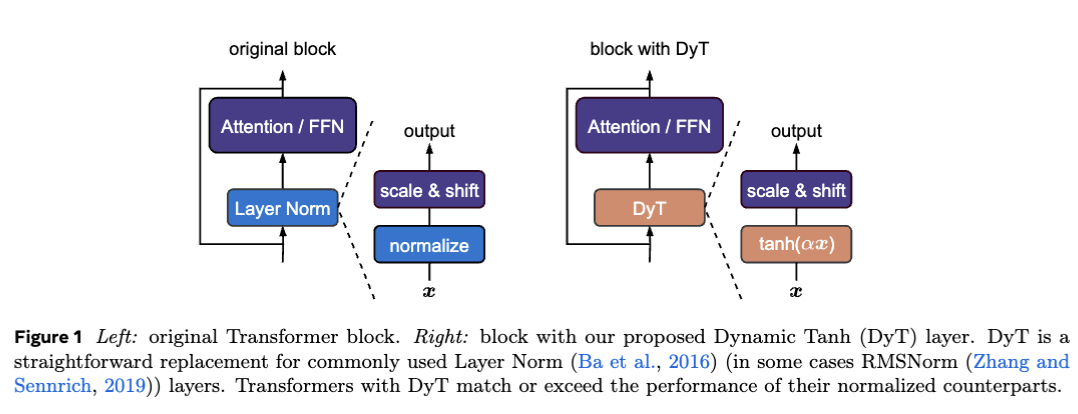

Using device: cpu
Loaded Data: (1115394 characters, vocab size 65)
Training Model: LayerNorm (LayerNorm)
Trainable Parameters: 0.81 M
Max iterations: 5000
step: 1/5000, loss: 4.2591, mfu: 1.84%
step: 2/5000, loss: 3.9975, mfu: 8.54%
step: 3/5000, loss: 3.8520, mfu: 13.40%
step: 4/5000, loss: 3.7796, mfu: 11.98%
step: 5/5000, loss: 3.7679, mfu: 13.15%
step: 6/5000, loss: 3.7028, mfu: 13.61%
step: 7/5000, loss: 3.7033, mfu: 13.97%
step: 8/5000, loss: 3.6597, mfu: 11.73%
step: 9/5000, loss: 3.5985, mfu: 14.06%
step: 10/5000, loss: 3.6498, mfu: 12.40%
step: 11/5000, loss: 3.5743, mfu: 13.56%
step: 12/5000, loss: 3.5849, mfu: 14.04%
step: 13/5000, loss: 3.5475, mfu: 13.84%
step: 14/5000, loss: 3.5732, mfu: 12.76%
step: 15/5000, loss: 3.5380, mfu: 13.33%
step: 16/5000, loss: 3.5255, mfu: 10.99%
step: 17/5000, loss: 3.4883, mfu: 12.40%
step: 18/5000, loss: 3.4517, mfu: 13.62%
step: 19/5000, loss: 3.3899, mfu: 14.27%
step: 20/5000, loss: 3.4344, mfu: 12.64%
step: 21/5000, loss: 3.3468, mfu: 13

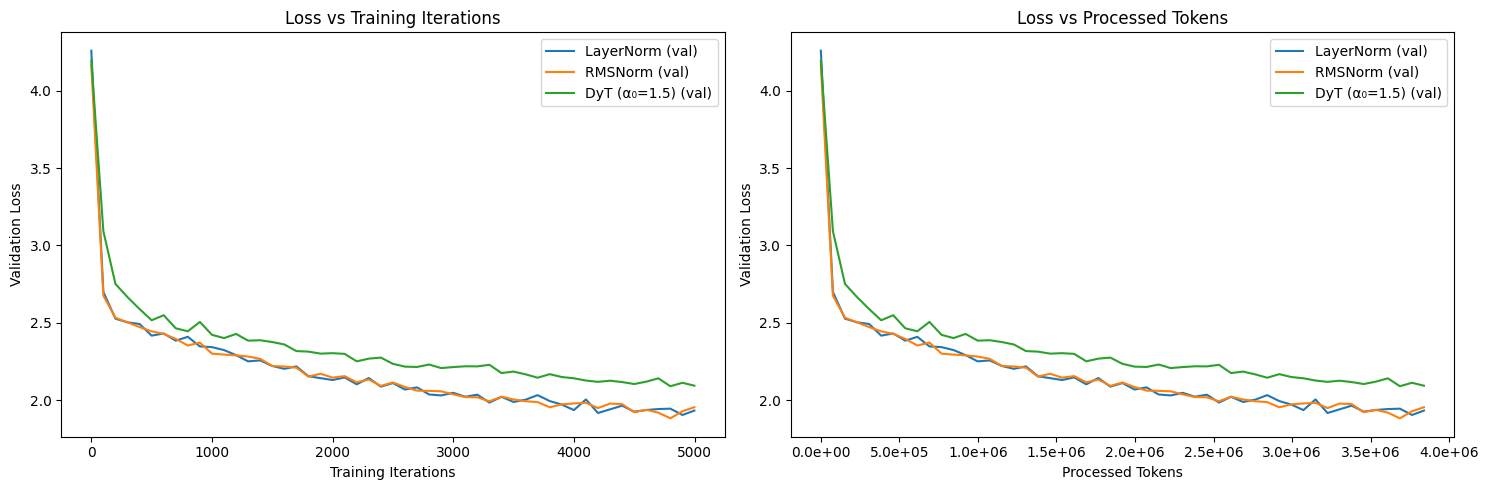

=== Sampling with LayerNorm ===


And you soo that man presstare of and sire bey not
ate the
Bore be pack that his sway the likenced.

BECAMBELO:
O his for man the tongersion:
And stand that and true you have gen plastance,
This by good yat come lover racin fath the do that he
song sirtans; and it his to his dotherelf,
And be the s
=== Sampling with RMSNorm ===

And doo that fortuse he leards, greaing and most of as
And the parle to mantrour, for we out of thee;
Wear'd of me for to dibe, as and with heare pear surtieng thee
to the wort the sake for be were prace well of dabe;
Thou for theire the with dames, sorrd better
This plence to art a in in the stand 
=== Sampling with DyT ===

Pie, awe coun surest as my my he,
Shourse, the your his hat with her thar my pie condise.

RINIUS:
The not:
That shat there shaw me an his he theat hey mattise
And en was his blity my for roun frens thear:
So be to and this boun dentear, thou he the I thim.


PENIN:
I whou you est con coust halll on

Scrip

In [ ]:
import os
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# Hyperparameters
batch_size = 12
block_size = 64
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0.2
init_alpha_dyt = 1.5 
norm_eps = 1e-5 
sample_max_new_tokens = 300
sample_temperature = 0.8
sample_top_k = 20
checkpoint_dir = 'checkpoints' 

print(f"Using device: {device}")
if device == 'cuda':
    try:
        print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    except Exception as e:
        print(f"Could not get CUDA device name: {e}")

# Load and preprocess data
try:
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    print(f"Loaded Data: ({len(text)} characters, vocab size {len(set(text))})")
except FileNotFoundError:
    print("Error: input.txt not found. Please ensure the file exists in the script directory.")
    exit()
except Exception as e:
    print(f"Error reading input.txt: {e}")
    exit()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s if c in stoi]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

if len(train_data) <= block_size or len(val_data) <= block_size:
    print(f"Warning: Dataset might be too small for block_size={block_size}. Train size: {len(train_data)}, Val size: {len(val_data)}")

def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    if len(data_split) <= block_size:
         raise ValueError(f"Data split '{split}' (length {len(data_split)}) is too small for block_size {block_size}.")
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i + block_size] for i in ix])
    y = torch.stack([data_split[i + 1:i + block_size + 1] for i in ix])
    return x.to(device), y.to(device)


class DynamicTanh(nn.Module):
    """Implements DyT(x) = weight * tanh(alpha * x) + bias"""
    def __init__(self, normalized_shape, init_alpha=0.5, eps=1e-5, **kwargs):
        super().__init__()
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = tuple(normalized_shape)
        self.alpha = nn.Parameter(torch.ones(1) * init_alpha)
        self.weight = nn.Parameter(torch.ones(self.normalized_shape))
        self.bias = nn.Parameter(torch.zeros(self.normalized_shape))
        self.eps = eps  

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        # apply DyT transformation
        return self.weight * torch.tanh(self.alpha * x_norm) + self.bias

    def extra_repr(self):
         return f'{self.normalized_shape}, init_alpha={self.alpha.item():.2f}, eps={self.eps}'


class RMSNorm(nn.Module):
    """Implements RMSNorm(x) = weight * x / sqrt(mean(x^2) + eps)"""
    def __init__(self, dim, eps=1e-5, **kwargs): 
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim)) # Learnable scale param

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

    def extra_repr(self):
         return f'{self.weight.shape}, eps={self.eps}'

LayerNorm = nn.LayerNorm

# --- MHA ---
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        assert n_embd % n_head == 0, "n_embd must be divisible by n_head"
        self.n_head = n_head
        self.head_size = n_embd // n_head
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)
        self.out = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        # Register buffer for attention masking
        self.register_buffer(
            "mask", 
            torch.tril(torch.ones(block_size, block_size))
            .view(1, 1, block_size, block_size)
        )
    
    def forward(self, x):
        batch_size, seq_len, n_embd = x.shape
        # Compute q, k, v
        k = self.key(x).view(batch_size, seq_len, self.n_head, self.head_size).transpose(1, 2)
        q = self.query(x).view(batch_size, seq_len, self.n_head, self.head_size).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.n_head, self.head_size).transpose(1, 2)
        
        # Compute attention scores
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # Apply causal mask
        att = att.masked_fill(self.mask[:,:,:seq_len,:seq_len] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        out = att @ v # (batch_size, n_head, seq_len, head_size)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, n_embd)
        return self.out(out)

class MLP(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.c_fc = nn.Linear(n_embd, 4 * n_embd)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embd, n_head, norm_class, **norm_kwargs):
        super().__init__()
        self.ln1 = norm_class(n_embd, **norm_kwargs)
        self.attn = MultiHeadAttention(n_embd, n_head)
        self.ln2 = norm_class(n_embd, **norm_kwargs)
        self.mlp = MLP(n_embd)
        
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class nanoGPT(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, norm_class, **norm_kwargs):
        super().__init__()
        self.block_size, self.vocab_size = block_size, vocab_size
        self.n_embd, self.n_head, self.n_layer = n_embd, n_head, n_layer
        self.norm_class_name = norm_class.__name__

        block_norm_kwargs = norm_kwargs.copy()
        final_norm_kwargs = norm_kwargs.copy()
        
        if norm_class == DynamicTanh:
            final_norm_kwargs = block_norm_kwargs

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd),
            wpe = nn.Embedding(block_size, n_embd),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, norm_class=norm_class, **block_norm_kwargs) for _ in range(n_layer)]),
            norm_f = norm_class(n_embd, **final_norm_kwargs)
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # Weight tying

        if norm_class == DynamicTanh:
            self.emb_scale = math.sqrt(n_embd)
        else:
            self.emb_scale = 1.0

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * n_layer))

        self.parameter_count = sum(p.numel() for p in self.parameters() if p.requires_grad) / 1e6

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        if t > self.block_size:
            idx, t = idx[:, :self.block_size], self.block_size
        if targets is not None and t < targets.size(1):
            targets = targets[:, :t]

        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        x = x * self.emb_scale
        
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.norm_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            if torch.isnan(logits).any():
                print("Warning: NaN detected in logits!")
                return logits, torch.tensor(float('nan'), device=device)
            try:
                loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            except Exception as e:
                print(f"Error calculating loss: {e}")
                loss = torch.tensor(float('nan'), device=device)
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        self.eval()
        for i in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            if torch.isnan(logits).any(): print(f"Warning: NaN logits gen step {i+1}. Stopping."); break
            logits = logits[:, -1, :] / temperature
            if top_k is not None: v, _ = torch.topk(logits, min(top_k, logits.size(-1))); logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            if torch.isnan(probs).any(): print(f"Warning: NaN probs gen step {i+1}. Stopping."); break
            try: idx_next = torch.multinomial(probs, num_samples=1)
            except RuntimeError as e: print(f"Error sampling step {i+1}: {e}\nProbs: {probs}"); break
            idx = torch.cat((idx, idx_next), dim=1)
        self.train(); return idx


# MFU Calculation
def compute_mfu(model, dt):
    if not all(hasattr(model, attr) for attr in ['n_layer', 'n_embd', 'block_size']): return 0.0
    N = sum(p.numel() for p in model.parameters() if p.requires_grad)
    L, H, T = model.n_layer, model.n_embd, model.block_size
    flops_per_token = 6 * N + 12 * L * H * T; global batch_size
    flops_per_fwdbwd = flops_per_token * T * batch_size
    flops_achieved = flops_per_fwdbwd / dt if dt > 0 else 0; flops_promised = 1e12
    if device == 'cuda':
        try:
            dev_name = torch.cuda.get_device_name(0).upper()
            if 'A100' in dev_name: flops_promised = 312e12
            elif 'H100' in dev_name: flops_promised = 1979e12
            elif 'V100' in dev_name: flops_promised = 125e12
            elif 'TESLA T4' in dev_name or ' T4' in dev_name: flops_promised = 65e12
            elif 'RTX 4090' in dev_name: flops_promised = 82.6e12
            elif 'RTX 3090' in dev_name: flops_promised = 35.6e12
        except Exception: pass
    mfu = flops_achieved / flops_promised if flops_promised > 0 else 0.0; return mfu


# Eval Func
@torch.no_grad()
def estimate_loss(model):
    out = {}; model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            try: X, Y = get_batch(split); _, loss = model(X, Y)
            except ValueError: loss = torch.tensor(float('nan'))
            except Exception as e: print(f"Error during {split} eval k={k}: {e}"); loss = torch.tensor(float('nan'))
            losses[k] = loss.item() if not torch.isnan(loss) else float('nan')
        out[split] = torch.nanmean(losses) if not torch.all(torch.isnan(losses)) else float('nan')
    model.train(); return out

# Global dict to store results for plots
all_results = {
    'LayerNorm': {'iters': [], 'val_losses': [], 'tokens': []},
    'RMSNorm': {'iters': [], 'val_losses': [], 'tokens': []},
    'DyT': {'iters': [], 'val_losses': [], 'tokens': []}
}
grad_clip_val = 0.5  

# Training
def train_model(model, model_type_key):
    print("=" * (30 + len(model_type_key) + len(model.norm_class_name)))
    print(f"Training Model: {model_type_key} ({model.norm_class_name})")
    print(f"Trainable Parameters: {model.parameter_count:.2f} M")
    print(f"Max iterations: {max_iters}")
    print("=" * (30 + len(model_type_key) + len(model.norm_class_name)))

    if model_type_key == 'DyT':
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate*0.8, betas=(0.9, 0.95), weight_decay=0.01)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95))
    
    run_iters, run_val_losses, run_tokens = [], [], []; t_start_training = time.time(); t0 = time.time()
    nan_loss_streak, max_nan_streak = 0, 10

    for iter_num in range(max_iters):
        if iter_num == 0 or iter_num % eval_interval == 0 or iter_num == max_iters - 1:
            loss_dict = estimate_loss(model); val_loss = loss_dict['val']
            run_iters.append(iter_num); run_val_losses.append(val_loss)
            run_tokens.append(iter_num * batch_size * block_size)

        try: xb, yb = get_batch('train')
        except ValueError as e: print(f"\n{e}. Stopping training for {model_type_key}."); break
        except Exception as e: print(f"\nError getting batch iter {iter_num}: {e}. Skipping."); continue

        try: _, loss = model(xb, yb)
        except Exception as e: print(f"\nError forward iter {iter_num}: {e}. Skipping."); t0 = time.time(); continue
        if torch.isnan(loss):
            print(f"\nWarning: NaN loss iter {iter_num}. Skipping."); nan_loss_streak += 1
            if nan_loss_streak >= max_nan_streak: print(f"Stopping training for {model_type_key} due to NaNs."); break
            t0 = time.time(); continue
        else: lossf = loss.item(); nan_loss_streak = 0

        optimizer.zero_grad(set_to_none=True)
        try: loss.backward()
        except Exception as e: print(f"\nError backward iter {iter_num}: {e}. Skipping step."); t0 = time.time(); continue
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val); 
        optimizer.step()

        t1 = time.time(); dt = t1 - t0; t0 = t1
        try: mfu = compute_mfu(model, dt); mfu_str = f"{mfu*100:.2f}%"
        except Exception: mfu_str = "N/A"
        print(f"step: {iter_num+1}/{max_iters}, loss: {lossf:.4f}, mfu: {mfu_str}")

    print(f"\nFinished training {model_type_key}. Total time: {time.time() - t_start_training:.2f}s")
    all_results[model_type_key]['iters'].extend(run_iters); all_results[model_type_key]['val_losses'].extend(run_val_losses); all_results[model_type_key]['tokens'].extend(run_tokens)

    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_{model_type_key}.pt")
    try: torch.save(model.state_dict(), checkpoint_path); print(f"Final model checkpoint saved to {checkpoint_path}")
    except Exception as e: print(f"Error saving final checkpoint for {model_type_key}: {e}")

def init_model(norm_class, **norm_kwargs):
    try: model = nanoGPT(vocab_size, n_embd, n_head, n_layer, block_size, norm_class=norm_class, **norm_kwargs).to(device); return model
    except Exception as e: print(f"Error initializing {norm_class.__name__} model: {e}"); exit()

# Init Models
ln_model = init_model(LayerNorm, eps=norm_eps)
rms_model = init_model(RMSNorm, eps=norm_eps)
dyt_model = init_model(DynamicTanh, init_alpha=init_alpha_dyt, eps=norm_eps)

# Train Models
train_model(ln_model, "LayerNorm")
train_model(rms_model, "RMSNorm")
train_model(dyt_model, "DyT")

# Plot curves
def plot_loss_curves(results):
    print("\nGenerating Plots...")
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    ax = axs[0]
    for key, style in [('LayerNorm', '-'), ('RMSNorm', '-'), ('DyT', '-')]:
        iters, losses = zip(*[(it, vl) for it, vl in zip(results[key]['iters'], results[key]['val_losses']) if not np.isnan(vl)])
        label = f'{key} (val)' if key != 'DyT' else f'DyT (α₀={init_alpha_dyt}) (val)'
        if iters: ax.plot(iters, losses, label=label, linestyle=style)

    ax.set_xlabel('Training Iterations'); ax.set_ylabel('Validation Loss'); ax.set_title('Loss vs Training Iterations')
    ax.legend(); 

    ax = axs[1]
    for key, style in [('LayerNorm', '-'), ('RMSNorm', '-'), ('DyT', '-')]:
         tokens, losses = zip(*[(tk, vl) for tk, vl in zip(results[key]['tokens'], results[key]['val_losses']) if not np.isnan(vl)])
         label = f'{key} (val)' if key != 'DyT' else f'DyT (α₀={init_alpha_dyt}) (val)'
         if tokens: ax.plot(tokens, losses, label=label, linestyle=style)

    ax.set_xlabel('Processed Tokens'); ax.set_ylabel('Validation Loss'); ax.set_title('Loss vs Processed Tokens')
    ax.legend(); ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1e'))

    plt.tight_layout()
    try: plt.show()
    except Exception as e: print(f"Error displaying plot: {e}")
    plt.close()

if any(all_results[key]['iters'] for key in all_results):
    plot_loss_curves(all_results)
else:
    print("\nSkipping plotting as no training results were generated.")

# --- Sample func ---
def sample(model_type_key, norm_class, **norm_kwargs):
    model = init_model(norm_class, **norm_kwargs)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_{model_type_key}.pt")
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found at {checkpoint_path}. Skipping sampling."); print("-" * 50); return
    try: state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True); model.load_state_dict(state_dict); 
    except Exception as e: print(f"Error loading checkpoint for {model_type_key}: {e}. Skipping sampling."); print("-" * 50); return

    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    print(f"=== Sampling with {model_type_key} ===")
    try:
        generated_indices = model.generate(context, max_new_tokens=sample_max_new_tokens, temperature=sample_temperature, top_k=sample_top_k)[0].tolist()
        print(decode(generated_indices))
    except Exception as e: print(f"Error during sampling for {model_type_key}: {e}")
    print("=" * 50)

# --- Sample ---
sample("LayerNorm", LayerNorm, eps=norm_eps)
sample("RMSNorm", RMSNorm, eps=norm_eps)
sample("DyT", DynamicTanh, init_alpha=init_alpha_dyt, eps=norm_eps)